# Imports

In [1]:
# Adding utils directory to the path
from pathlib import Path
cwd = Path.cwd()
import sys
sys.path.append(str(cwd.joinpath("utils")))

In [2]:
# Importing custom collections of utils
import az_tools as az
reload(az)
import az_model as azm
reload(azm)
import az_plot as azp
reload(azp)

<module 'az_plot' from 'C:\Users\smnar\az_network_droplets\utils\az_plot.pyc'>

In [3]:
# Importing external packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import stats
from scipy.stats import linregress
from scipy.optimize import least_squares
from scipy.integrate import odeint
import networkx as nx
from itertools import combinations, permutations, chain
from random import random, sample, randint

# Matplotlib configuration

In [4]:
%matplotlib inline
c = %config InlineBackend.rc
c['savefig.dpi'] = 110
%config InlineBackend.figure_format='png'
%config InlineBackend.rc = c
%matplotlib inline

In [5]:
from cycler import cycler
colors = [u'#1b9e77', u'#d95f02', u'#7570b3', u'#e7298a', u'#66a61e', u'#e6ab02', u'#a6761d', u'#666666']
almost_black = "0.2"
golden = 1.618
mpl.rcParams['axes.edgecolor'] = almost_black
mpl.rcParams['axes.labelcolor'] = almost_black
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.prop_cycle'] = cycler(u'color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['legend.fontsize'] = "medium"
mpl.rcParams['legend.numpoints'] = 1
mpl.rcParams['legend.scatterpoints'] = 1
mpl.rcParams['legend.edgecolor'] = "w"
mpl.rcParams['legend.loc'] = "upper left"
mpl.rcParams['text.color'] = almost_black
mpl.rcParams['xtick.color'] = almost_black
mpl.rcParams['ytick.color'] = almost_black
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['figure.figsize'] = [3.5, 3.5/golden]
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']

# Utils

### General

In [6]:
E = [l.strip().split(",") for l in open(str(cwd.joinpath("utils/initial_emulsions.txt"))).readlines()]
HP = ["hp_%s"%i for i in range(24)]

### Experimentally measured kinetic rates

In [7]:
# ka is in /min
ka = {"AU":0.001352, "UA":0.001575, "CG":0.004950, "GC":0.00308, "GU":0.000160, "UG":0.000066}
for g in az.G:
    if g not in ka.keys():
        ka[g] = 0.0000018
ka_rates = [ka[g] for g in az.G]

# kb is in µM/min
kb = {"AU":0.000038, "UA":0.000150, "CG":0.000474, "GC":0.000552, "GU":0.000015, "UG":0.000005}
for g in az.G:
    if g not in kb.keys():
        kb[g] = 0.00000
kb_rates = [kb[g] for g in az.G]        

rates = az.norm_array(kb_rates[:]) # Default model is the in-degree model

# Processing the azoarcus network droplets data 

Sequencing data have been processed to extract metadata as described in Material and Methods. Reads have been collapsed based on their UMI and UMI-normalized reads have been filtered based on thresholds which have been determined as described in Material and Methods. <br> The data have then been aggregated per droplet (using the droplet barcode information) and saved as a csv file ("az_network_droplets_final_dataset.csv"). It is this csv file which is now loaded and processed by notably filtering out droplets with low numbers of UMIs.

In [8]:
data = pd.read_csv("az_network_droplets_final_dataset.csv", converters={"az_list":str})
print(data.sample(5))

         AA   AC   AG   AU   CA   CC   CG   CU   GA   GC  ...  \
433744  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   
403253  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
222123  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
328174  0.0  0.0  2.0  0.0  0.0  1.0  3.0  0.0  0.0  0.0  ...   
83213   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

                 hp_list           az_list  nb_hp  nb_az  az_correct  \
433744                []  0000000000000000      0      0    0.000000   
403253                []  0000000000000000      0      0    0.000000   
222123                []  0000000000000000      0      0    0.000000   
328174  [15, 18, 19, 22]  0000111000000011      4      5    0.222222   
83213               [13]  0101000000000000      1      2    0.000000   

        hp_correct       dth  dth_normed      dpBC  spBC_letter  
433744         0.0  0.000000    0.000000  94#58#14            A  
403253         0.0  0.000000    0.000000  89

In [9]:
data_, data_f = az.filter_az_droplet_data(data, [10, 20])
print(data_.sample(5))

C:\Users\smnar\az_network_droplets\utils\az_tools.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data_temp["yield"] = data_temp.apply(compute_yield, axis=1)
C:\Users\smnar\az_network_droplets\utils\az_tools.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data_temp["az_gd"] = data_temp.apply(genotype_distribution, axis=1)


       AA        AC        AU        AG        CA        CC        CU  \
333   0.0  0.000000  0.000000  0.000000  0.007261  0.026890  0.000000   
860   0.0  0.982143  0.000000  0.000000  0.000000  0.000000  0.017857   
984   0.0  0.529449  0.000000  0.242205  0.000000  0.000000  0.000000   
867   0.0  0.236929  0.000000  0.000000  0.000000  0.000000  0.004209   
1823  0.0  0.283582  0.089552  0.462687  0.014925  0.029851  0.000000   

            CG   UA   UC  ...        UG   GA        GC        GU        GG  \
333   0.000000  0.0  0.0  ...  0.185648  0.0  0.778434  0.001767  0.000000   
860   0.000000  0.0  0.0  ...  0.000000  0.0  0.000000  0.000000  0.000000   
984   0.000000  0.0  0.0  ...  0.000000  0.0  0.000000  0.000000  0.187810   
867   0.000000  0.0  0.0  ...  0.028914  0.0  0.586391  0.000000  0.143557   
1823  0.119403  0.0  0.0  ...  0.000000  0.0  0.000000  0.000000  0.000000   

               az_list      az_UMI       yield  nb_az  \
333   0000111000110110  199.500000 

# Fig 1d

Script used to produce Circos input data files.

In [17]:
def write_plot_file(filename, var_attr, fixed_attr={}, fixed_line=""):
    with open(filename, "w") as f:
        for j in range(len(var_attr.values()[0])):
            f.write("<plot>\n\n")
            for k, v in fixed_attr.items():
                f.write("%s%s = %s\n"%(k, " "*(30-len(k)), v))
            f.write(fixed_line)
            for k, v in var_attr.items():
                f.write("%s%s = %s\n"%(k, " "*(30-len(k)), v[j]))
            f.write("\n</plot>\n\n\n")

In [19]:
temp = data_.sort_values(by="nb_az")
list_nt = list(temp.az_list.values)
ix_nt = range(len(list_nt))
pad = 10
color_nt = ["set3-12-qual-%s"%np.random.randint(1, 12) for nt in list_nt]
offset = 15
current_size = 1
for i, nt in enumerate(list_nt):
    if nt.count("1") > current_size: 
        offset += pad
        current_size += 1
    ix_nt[i]  += offset
#shuffle(list_nt)

new_size_ix = list(np.array(ix_nt)[list((np.array(ix_nt) - np.array([0] + ix_nt)[:-1] - 1) > 0)])
new_size_ix = list((np.array(new_size_ix)[1:] + np.array(new_size_ix)[:-1])/2 - pad/2) + [new_size_ix[-1]-1]

#karyotypes with chr = nb of networks of a size * size of networks
with open("figures/circos/data/karyotype.txt", "w") as f:
    for i in range(ix_nt[-1]+pad):
        f.write("chr - az%s %s 0 10 blue\n"%(i, i))
        
#labels
with open("figures/circos/data/labels.txt", "w") as f:
    for j, i in enumerate(new_size_ix):
        f.write("az%s 0 0 %s\n"%(i, j+1))

#links
with open("figures/circos/data/links.txt", "w") as f:
    D = az.az_networks_graph(list_nt)
    D = nx.from_numpy_matrix(D)
    for e in D.edges():
        color = "black_a5 thickness=1"
        f.write("az%s 5 6 az%s 5 6 color=%s\n"%(ix_nt[e[0]], ix_nt[e[1]], color))

#data
for k in range(16):
    with open("figures/circos/data/heatmap_%s.txt"%k, "w") as f:
        for i, nt in enumerate(list_nt):
            if nt[k] == "1":
                #Color = fraction
                s = "az%s 0 10 %.3f\n"%(ix_nt[i], data_[data_.az_list == nt].az_gd.values[0][az.transform(nt).index(az.G[k])])
                #Color = node identity
                #s = "az%s 0 10 %s\n"%(ix_nt[i], G.index(azm.transform(nt)[k-1]))
                f.write(s)

track_width = 0.03
track_pad = 0.001
track_start = 1.00

write_plot_file("figures/circos/etc/plots_hm.conf", 
                var_attr={"file":["data/heatmap_%s.txt"%i for i in range(16)],
                          'r0':["%sr"%(track_start + i*(track_width+track_pad)) for i in range(16)],
                          'r1':["%sr"%(track_start + i*(track_width+track_pad) + track_width) for i in range(16)]},
                fixed_attr={'type':'heatmap', 'color':'spectral-10-div-rev', 'stroke_thickness':'1', 'stroke_color':'white', 'min':'0', 'max':'1', 'scale_log_base':'0.5'})

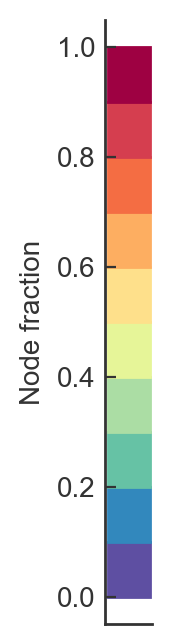

In [20]:
hm = [(158,1,66), (213,62,79), (244,109,67), (253,174,97), (254,224,139), (230,245,152), (171,221,164), (102,194,165), (50,136,189), (94,79,162)]
f = plt.figure(figsize=(0.3, 4))
ax = plt.gca()
for j, c in enumerate(np.array(hm)[::-1]):
    ax.fill([0, 0, 1, 1], [0.1*j, 0.1*(j+1), 0.1*(j+1), 0.1*j], color=map(lambda x: x/255., c))
ax.axes.get_xaxis().set_visible(False)
ax.set_ylabel("Node fraction")
f.savefig(str(cwd.joinpath("figures/1d_colorbar.svg")), fmt='svg')

# Fig 1e

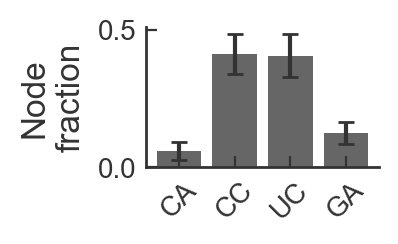

In [21]:
nt = az.transform(['CA', 'CC', 'UC', 'GA'])
size = nt.count("1")
Y = np.vstack(data_f[data_f.az_list == nt].az_gd.values)

f = plt.figure(figsize=(1.5, 1.5/golden))
ax = plt.gca()
ax.bar(range(size), Y.mean(0), yerr=Y.std(0), color=azp.colors[7], capsize=3, ecolor=almost_black)
ax.set_xticks(range(size))
ax.set_xticklabels(az.transform(nt), rotation=45)
ax.tick_params(labelsize=10)
ax.set_ylabel("Node\nfraction", fontsize=12)
ylim = ax.get_ylim()[1]
ax.set_ylim(0, ylim)
f.savefig(str(cwd.joinpath("figures/1e_top.svg")), fmt='svg')
ylim = ax.get_ylim()

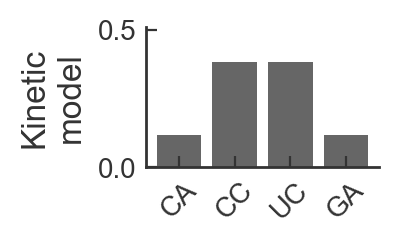

In [22]:
f = plt.figure(figsize=(1.5, 1.5/golden))
ax = plt.gca()
Y = azm.az_kinetic_model(nt, 60, ka_rates, kb_rates)
ax.bar(range(size), Y, color=azp.colors[7], capsize=3, ecolor=almost_black)
ax.set_xticks(range(size))
ax.set_xticklabels(az.transform(nt), rotation=45)
ax.tick_params(labelsize=10)
ax.set_ylabel("Kinetic\nmodel", fontsize=12)
ax.set_ylim(ylim)
f.savefig(str(cwd.joinpath("figures/1e_bottom.svg")), fmt='svg')

# Fig 1d

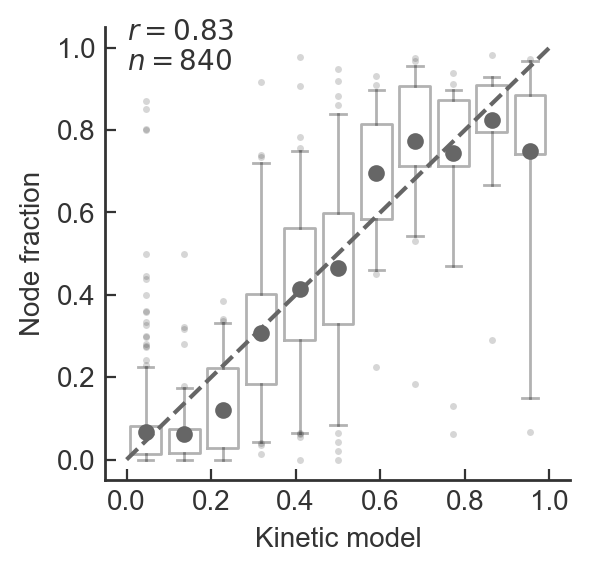

In [211]:
size = 4
temp = data_[data_.nb_az == size]
# X = np.hstack(temp.az_list.apply(lambda x: [azm.degree(g, x, 1, 'in', rates) for g in azm.transform(x)]).values)
X = np.hstack(temp.az_list.apply(lambda x: azm.az_kinetic_model(x, 60, ka_rates, kb_rates)).values)
Y = np.hstack(temp.az_gd.values)

f = plt.figure(figsize=(3, 3))
ax = plt.gca()
bxp = azp.styled_boxplot(ax, X, Y, nbins=np.linspace(0, 1, 12), nb_points=10, showfliers=True, alphafliers=0.2, alpha=0.3, whis=[5, 95], ticks=False, color=azp.colors[7]);
ax.plot([0, 1], [0, 1], "--", color=azp.colors[7])
h = 0.05
ymin, ymax = 0, 1
xmin, xmax = 0, 1
ax.set_xlim(xmin-h, xmax+h)
ax.set_ylim(ymin-h, ymax+h)
ax.set_yticks([0., 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticks([0., 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticklabels(map(lambda x: "%.1f"%x, [0., 0.2, 0.4, 0.6, 0.8, 1.0]))
ax.set_xlabel("Kinetic model")
ax.set_ylabel("Node fraction")
lr = stats.linregress(X, Y)
ax.text(xmin, ymax, r"$r=%.2f$"%lr.rvalue + "\n" + r"$n=%s$"%len(X), va='center')
f.savefig(str(cwd.joinpath("figures/1d.svg")), fmt='svg')

# Perturbation analysis

In [10]:
%%time
tmp = data_[data_.nb_az > 1]

node_fraction_data = {x.az_list:x.az_gd for _, x in tmp.iterrows()}
epi = az.perturbation_analysis(node_fraction_data)

node_fraction_data_eig = {x:azm.eig_centrality(x, rates)[0] for x in tmp.az_list}
epi_eig = az.perturbation_analysis(node_fraction_data_eig)

Wall time: 1min 3s


# Fig 2a

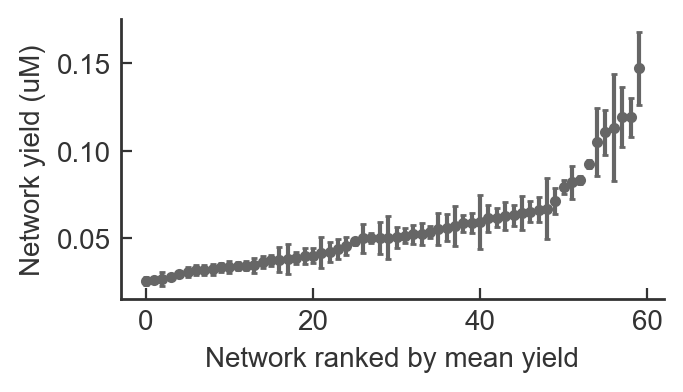

In [201]:
tmp = data_f[data_f.nb_az == 4].groupby("az_list").filter(lambda x: len(x) >= 10)
tmp["yield"] = tmp["yield"].values*1e-3
y = tmp.groupby("az_list").mean().get("yield").values
yerr = tmp.groupby("az_list").sem().get("yield").values
O = y.argsort()

f = plt.figure(figsize=(3.5, 3/golden))
ax = plt.gca()
ax.errorbar(range(len(y)), y[O], yerr[O], fmt=".", color=azp.colors[7], capsize=1)
ax.set_xlabel("Network ranked by mean yield")
ax.set_ylabel("Network yield (uM)")
f.savefig(str(cwd.joinpath("figures/2a.svg")), fmt='svg')

# Fig 2b

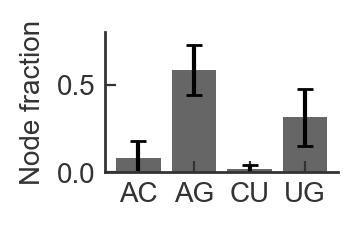

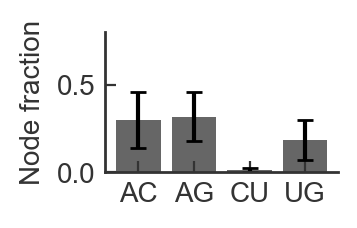

In [150]:
before = az.transform(["AC", "AG", "CU", "UG"])
after = az.transform(["AC", "AG", "CU", "UG", "GG"])
y = epi[(epi.before == before) & (epi.after == after)]
y_before = np.vstack(data_f[data_f.az_list == before].az_gd.values).mean(0)
# Only because mutation == GG so it's the last element of the list
y_after = (np.vstack(data_f[data_f.az_list == after].az_gd.values)[:, :-1]).mean(0)
ylim = 0.8

f = plt.figure(figsize=(1.5, 1.5/golden))
ax = plt.gca()
ax.bar(range(4), y_before, yerr=np.vstack(data_f[data_f.az_list == before].az_gd.values).std(0), color=azp.colors[7], capsize=3)
ax.set_ylim(0, ylim)
ax.set_xticks(range(4))
ax.set_xticklabels(y.order_sp.values[0])
ax.set_ylabel("Node fraction")
f.savefig(str(cwd.joinpath("figures/2b_left.svg")), fmt='svg')

f = plt.figure(figsize=(1.5, 1.5/golden))
ax = plt.gca()
ax.bar(range(4), y_after, yerr=(np.vstack(data_f[data_f.az_list == after].az_gd.values)[:, :-1]).std(0), color=azp.colors[7], capsize=3)
ax.set_ylim(0, ylim)
ax.set_xticks(range(4))
ax.set_xticklabels(y.order_sp.values[0])
ax.set_ylabel("Node fraction")
f.savefig(str(cwd.joinpath("figures/2b_right.svg")), fmt='svg')

# Fig 2c

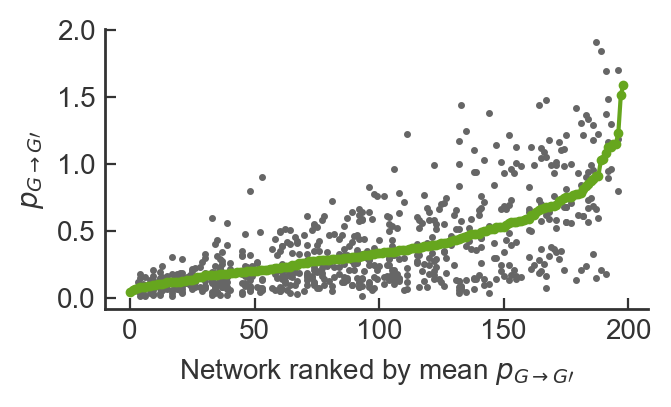

In [153]:
size = 4
temp = az.collapse_postprocess(az.postprocess_perturbation_analysis(4, epi, rates), rates)
order_nt = temp.groupby("before").mean().reset_index().sort_values("abs_p_v").before.values
Y = [temp[temp.before == nt].abs_p_v.values for nt in order_nt]

f = plt.figure(figsize=(3.5, 3/golden))
ax = plt.gca()
ax.plot(np.hstack([[i]*len(Y[i]) for i in range(len(Y))]), np.hstack(Y), '.', color=azp.colors[7], ms=3)
ax.plot(range(len(Y)), map(np.mean, Y), ".-", color=azp.colors[4], ms=5)
ax.set_ylabel(r"$p_{G \rightarrow G\prime}$")
ax.set_xlabel("Network ranked by mean "+r"$p_{G \rightarrow G\prime}$")
f.savefig(str(cwd.joinpath("figures/2c_right.svg")), fmt='svg')

# Fig 2d

In [14]:
# Importing custom collections of utils
import az_tools_ as az_old
reload(az)
import az_model_ as azm_old
reload(azm)
import az_plot_ as azp_old
reload(azp)

<module 'az_plot' from 'C:\Users\smnar\az_network_droplets\utils\az_plot.pyc'>

In [48]:
temp_epi = epi[epi.before.apply(lambda x: azm.network_matrix(x, rates).sum() > 0)]
temp = [az.collapse_postprocess(az.postprocess_perturbation_analysis(s, temp_epi, rates), rates) for s in [3, 4, 5]]

In [49]:
s = 0
for tmp in temp:
    r = len(tmp[tmp.is_cat_innov & tmp.mutation.apply(lambda x: x[0] in "GC")])
    print(r)
    s += r
print(s)

73
75
33
181


In [81]:
temp_epi = epi[epi.before.apply(at_least_one_WC_link)]
temp = pd.concat([az.collapse_postprocess(az.postprocess_perturbation_analysis(s, temp_epi, rates), rates) for s in [3, 4, 5]])
temp_ = temp[temp.is_cat_innov & temp.mutation.apply(lambda x: x[0] in "GC")]
data_yield = {x.az_list:x.get("yield") for (_,x) in data_.iterrows()}
temp_["yield"] = temp_.before.apply(lambda x: data_yield[x])

C:\Users\smnar\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [82]:
len(temp_)

176

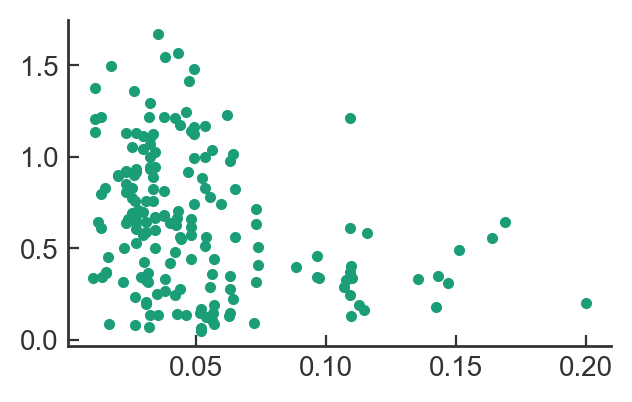

In [83]:
f = plt.figure()
ax = plt.gca()
ax.plot(temp_["yield"].values*1e-3, temp_.abs_p_v, '.')

# Fig 3b

In [104]:
def plot_aux_data(perturb_data, ax, m, n, color, xmax=200, fmt="o-", ms=7, mew=1.5, lw=1.5, cs=3):
    temp = pertub_data[(np.isclose(pertub_data.m, m)) & (np.isclose(pertub_data.n, n))]
    nbins = 20
    xbins = np.logspace(np.log10(0.08/0.42), np.log10(xmax), nbins+1)
    ix = np.digitize(temp.sigma_e, xbins) - 1
    y_ = np.array([temp.abs_p_v[ix == i].mean() for i in range(nbins)])
    z_ = np.array([temp.abs_p_v[ix == i].std() for i in range(nbins)])
    w_ = np.array([len(temp.abs_p_v[ix == i]) for i in range(nbins)])
    x_ = np.array([np.log10((xbins[i] + xbins[i+1])*0.5) for i in range(nbins)])
    M = np.invert(np.isnan(y_)) * (w_ >= 3)
    if ax != None:
        ax.errorbar(x_[M], y_[M], yerr=z_[M], fmt=fmt, 
                    color=color, mec=color,
                    ms=ms, markerfacecolor="w", markeredgewidth=mew, capsize=cs, linewidth=lw)
    y = np.array([temp.abs_p_v[ix == i].values for i in range(nbins)])
    return (x_, y)
    
def plot_aux_th(ax, m, n, color, xmax=200, lw=1.5, label=""):
    xmin = max(n*m, 0.08/0.42)+0.05
    x = np.logspace(np.log10(xmin), np.log10(xmax), 100)
    y = 2*n*(1-(m*n)/x)/(x+n)
    ax.plot(np.log10(x), y, color=color, lw=lw, label=label)
    
def tick_aux(ax):
    mjt, mjtlab, mnt = azp.custom_log_ticks(-1, 3, base_10=True)
    ax.set_xticks(mjt, minor=False)
    ax.set_xticks(mnt, minor=True)
    ax.set_xticklabels(mjtlab)
    ax.set_xlim(-1, 2.5)
    ax.set_ylabel(r"$p^{G \rightarrow G'}$", fontsize=14)
    ax.set_xlabel(r"$\sigma_e$", fontsize=14)
    ax.xaxis.set_ticks_position("bottom")
    ax.yaxis.set_ticks_position("left")
    
def plot_fig3b(perturb_data, m, n, c):
    x, y = [2, 2], [1, 1.2]
    f, axa = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(7, 3.5/golden))
    ax = plt.gca()
    plot_aux_data(perturb_data, axa[0], m[0], n[0], azp.colors[c[0]])
    plot_aux_th(axa[1], m[0], n[0], azp.colors[c[0]])
    plot_aux_data(perturb_data, axa[0], m[1], n[1], azp.colors[c[1]])
    plot_aux_th(axa[1], m[1], n[1], azp.colors[c[1]])
    for i in range(2):
        axa[i].text(x[0], y[0], r"$m=%s$"%0 + ", " + r"$n=%s$"%1, color=azp.colors[c[0]], ha='center')
        axa[i].text(x[1], y[1], r"$m=%s$"%0 + ", " + r"$n=%s$"%2, color=azp.colors[c[1]], ha='center')
        tick_aux(axa[i])
        axa[i].xaxis.set_ticks_position("bottom")
        axa[i].yaxis.set_ticks_position("left")
        axa[i].set_ylim(-0.25, 1.8)
    return f

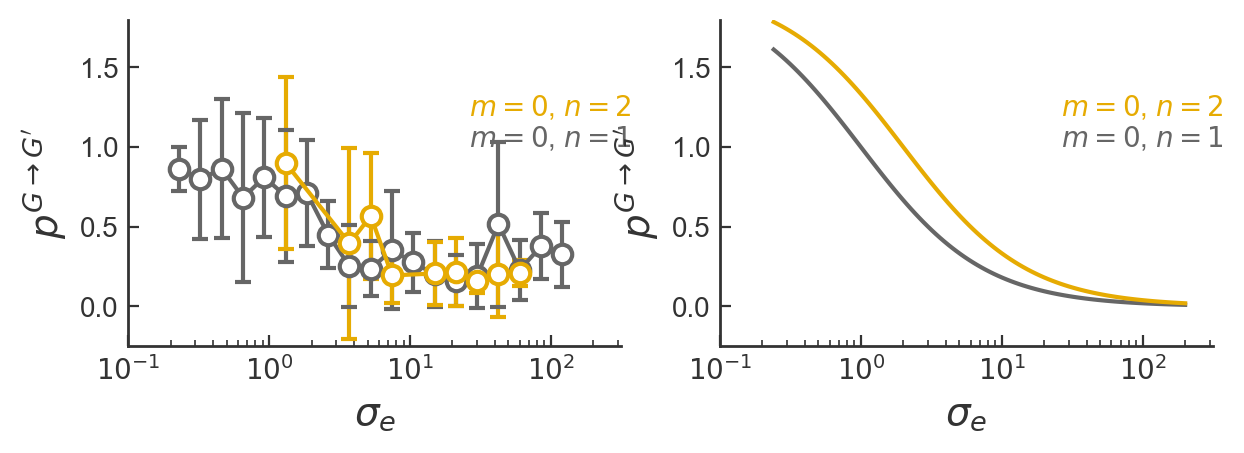

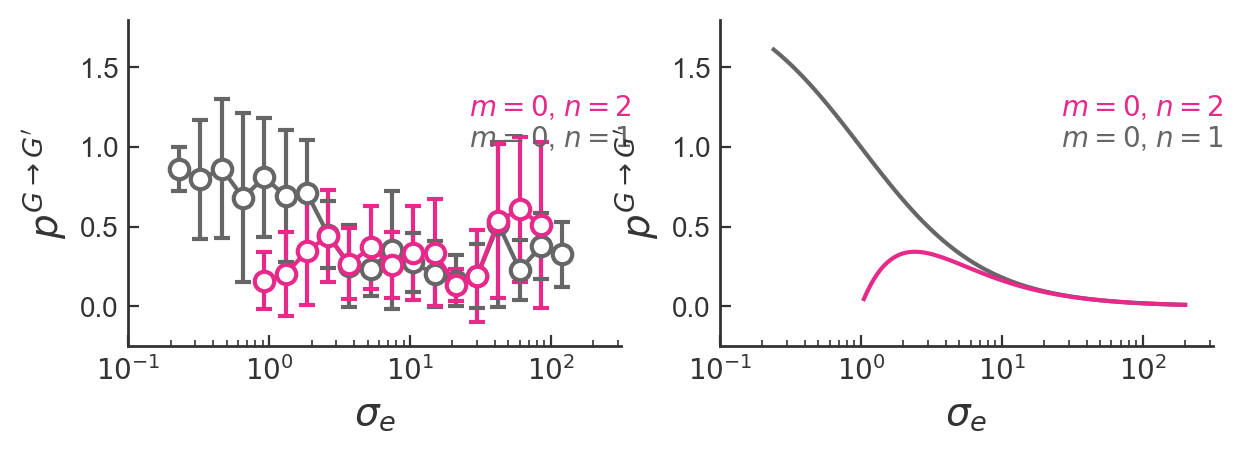

In [154]:
pertub_data = pd.concat([az.collapse_postprocess(az.postprocess_perturbation_analysis(s, epi[epi.before.apply(az.at_least_one_WC_link)], rates), rates) for s in [3, 4]])

f = plot_fig3b(pertub_data, [0, 0], [1, 2], [7, 5])
f.savefig(str(cwd.joinpath("figures/3b_top.svg")), fmt='svg')

f = plot_fig3b(pertub_data, [0, 1], [1, 1], [7, 3])
f.savefig(str(cwd.joinpath("figures/3b_bottom.svg")), fmt='svg')

# Fig 3c

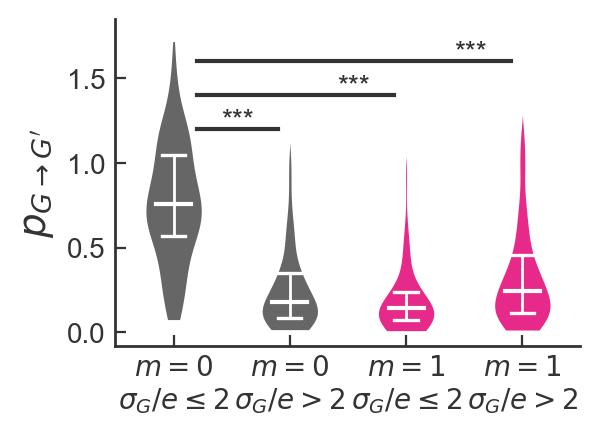

In [155]:
X0, Y0 = plot_aux_data(pertub_data, None, 0, 1, azp.colors[7])
X1, Y1 = plot_aux_data(pertub_data, None, 1, 1, azp.colors[3])
tmp = [np.hstack(Y0[X0 <= np.log10(2)]), 
       np.hstack(Y0[X0 > np.log10(2)]), 
       np.hstack(Y1[X1 <= np.log10(2)]),
       np.hstack(Y1[X1 > np.log10(2)])]
vmp = pd.DataFrame(tmp).T
vmp.columns = ["A:m=0,sigma/e<2",
               "B:m=0,sigma/e>2",
               "C:m=1,sigma/e<2",
               "D:m=1,sigma/e>2"]

f = plt.figure(figsize=(3, 3.5/golden))
ax = plt.gca()
parts = ax.violinplot(tmp, showmedians=False, showextrema=False)
for i in range(4):   
    q = [np.percentile(tmp[i], x) for x in [25, 50, 75]]
    
    w = 0.1
    ax.plot([(i+1)-w, (i+1)+w], [q[0]]*2, color="w", linewidth=1.2)
    ax.plot([(i+1)-w, (i+1)+w], [q[2]]*2, color="w", linewidth=1.2)

    w = 0.15
    ax.plot([(i+1)-w, (i+1)+w], [q[1]]*2, color="w", linewidth=1.5)
    ax.plot([i+1]*2, [q[0], q[2]], color="w", linewidth=1)
    
tmp_color = [azp.colors[j] for j in [7, 7, 3, 3]]
for j, pc in enumerate(parts['bodies']):
    pc.set_facecolor(tmp_color[j])
    pc.set_edgecolor("w")
    pc.set_alpha(1)
ax.set_ylim(-0.08, 1.85)
ax.set_xlim(0.5, 4.5)
ax.set_xticks(range(1, 5))
ax.set_ylabel(r"$p_{G \rightarrow G'}$", fontsize=14)
ax.set_xticklabels([r"$m=0$"+"\n"+r"$\sigma_G/e \leq 2$", 
                    r"$m=0$"+"\n"+r"$\sigma_G/e > 2$", 
                    r"$m=1$"+"\n"+r"$\sigma_G/e \leq 2$",
                   r"$m=1$"+"\n"+r"$\sigma_G/e > 2$"], 
                   fontsize=10, rotation=0)
t_tests = [stats.ttest_ind(tmp[i], tmp[j]) for i, j in zip([0, 0, 0], [1, 2, 3])]
u_tests = [stats.mannwhitneyu(tmp[i], tmp[j]) for i, j in zip([0, 0, 0], [1, 2, 3])]
ax.plot([1.2, 1.9], [1.2, 1.2], color=almost_black)
ax.text(1.55, 1.21, azp.what_pvalue(u_tests[0].pvalue), ha="center")
ax.plot([1.2, 2.9], [1.4, 1.4], color=almost_black)
ax.text(2.55, 1.41, azp.what_pvalue(u_tests[1].pvalue), ha="center")
ax.plot([1.2, 3.9], [1.6, 1.6], color=almost_black)
ax.text(3.55, 1.61, azp.what_pvalue(u_tests[2].pvalue), ha="center")

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

f.savefig(str(cwd.joinpath("figures/3c.svg")), fmt='svg')

# Fig 3d

In [156]:
temp = az.collapse_postprocess(az.postprocess_perturbation_analysis(4, epi, kb_rates), kb_rates).groupby("before").mean().reset_index()
temp["yield"] = temp.before.apply(lambda x: data_yield[x]*1e-3)
print(len(temp))

199


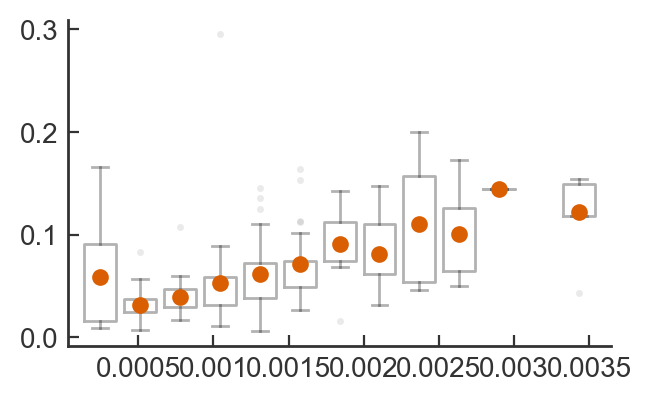

In [157]:
f = plt.figure()
ax = plt.gca()
azp.styled_boxplot(ax, temp.sigma_g, temp["yield"]);

# Fig 4b

In [165]:
# Importing custom collections of utils
import az_tools as az
reload(az)
import az_model as azm
reload(azm)
import az_plot as azp
reload(azp)

<module 'az_plot' from 'C:\Users\smnar\az_network_droplets\utils\az_plot.pyc'>

In [164]:
data_epi_dict = az.epi_dict(epi, rates)
gr = az.sample_graph_for_series(epi)

In [166]:
start = 3
end = 7
path = az.compute_series(start, end, data_epi_dict, gr)

In [169]:
N = len(path)
use_data = 1
only_GC = 1
temp = path.sample(N)
temp = [list(temp.path.values), list(temp.pscores.values)]
Y= [[], []]
X = []
IX = []
third_d = []
for i in range(N):
    y = np.array([0] + temp[1][i])
    dy = [y[j+1] - y[j] for j in range(len(y)-1)]
    ddy = [dy[j+1] - dy[j] for j in range(len(dy) - 1)]
    ix = []
    for j in range(end - start+1):
        if j > 0:
            mut = az.what_mut(temp[0][i][j], temp[0][i][j-1])[1]
            is_innovation = sum([g[0] == mut[0] for g in az.transform(temp[0][i][j-1])]) == 0 and sum([g[1] == az.base_comp[mut[0]] for g in az.transform(temp[0][i][j-1])]) > 0
            if mut[0] in "AU" and only_GC:
                is_innovation = False
        else:
            is_innovation = False
        ix.append(is_innovation)
    IX.append(ix)        
    ix = np.array(ix[1:-1])
    x = np.abs(np.diff(ddy))*(np.diff(np.sign(ddy) >= 0) * (np.sign(ddy) >= 0)[:-1])
    Y[1].append((ix*x)[np.nonzero(ix*x)])
    Y[0].append((~ix*x)[np.nonzero(~ix*x)])
    X.append(x[np.nonzero(x)])
    third_d.append(x)
Y = map(np.hstack, Y)

In [170]:
list_paths = [[['0000010000000011',
   '0000110000000011',
   '0000111000000011',
   '0100111000000011',
   '0110111000000011'],
  ['0000110000000010',
   '0000111000000010',
   '0000111000001010',
   '0000111001001010',
   '0000111001011010'],
  ['0000110000000010',
   '0000110000000110',
   '0100110000000110',
   '0100110000000111',
   '0100111000000111']],
 [['0101001000000000',
   '0101001000010000',
   '0101001000110000',
   '0101001000110001',
   '0101001000111001'],
  ['0100101000000000',
   '0101101000000000',
   '0101101000001000',
   '0111101000001000',
   '0111101000101000'],
  ['0101000000001000',
   '0111000000001000',
   '0111100000001000',
   '1111100000001000',
   '1111101000001000']],
 [['0101000000100000',
   '0101001000100000',
   '0101001000110000',
   '0101001000110001',
   '0101001000111001'],
  ['0111000000000000',
   '0111100000000000',
   '0111101000000000',
   '0111101000001000',
   '0111101000101000'],
  ['0101000000100000',
   '0101001000100000',
   '0101101000100000',
   '0101101000100010',
   '0101111000100010']]]
list_paths = map(lambda x: map(lambda y: "_".join(y), x), list_paths)

In [171]:
x = np.hstack(third_d)
np.percentile(x[x > 0], 75)

0.22601503993050226

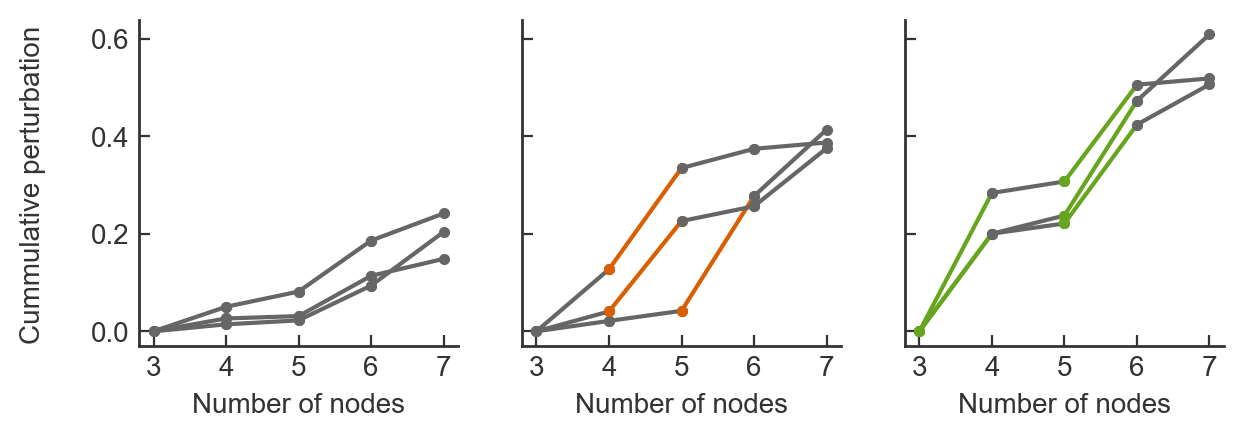

In [173]:
max_angle = 0.226
y = map(lambda x: [y > max_angle for y in x], third_d)
f, axa = plt.subplots(1, 3, figsize=(7, 3.5/golden), sharex=True, sharey=True)
for k in range(3):
    ax = axa[k]
    temp_ = pd.DataFrame([(temp[0][j], temp[1][j], IX[j]) for j in range(len(y)) if IX[j][1:-1] == y[j] and sum(IX[j]) == k and not IX[j][-1] and (k != 1 or not IX[j][1])], columns=["nt_path", "p_g", "in_x"])
    #temp_ = pd.DataFrame([(temp[0][j], temp[1][j], IX[j]) for j in range(len(y))], columns=["nt_path", "p_g", "in_x"])
    temp_["nt_path"] = temp_.nt_path.apply(lambda x: "_".join(x))
    for name, x in temp_[temp_.nt_path.isin(list_paths[k])].iterrows():
        #print(x)
        for j in range(len(x.p_g)-1):
            color = azp.colors[7]
            if x.in_x[j+1]: color = azp.colors[1 + 3*(k==2)]
            ax.plot([start+j, start+j+1], [x.p_g[j], x.p_g[j+1]], '.-', color=color)
        ax.set_xticks([3, 4, 5, 6, 7])
        ax.set_xlabel("Number of nodes")
f.text(0.04, 0.5, "Cummulative perturbation", va='center', rotation=90)
f.savefig(str(cwd.joinpath("figures/4b.svg")), fmt='svg')

# Fig 4c

Grey distribution, n=4462 
Orange distribution, n=934


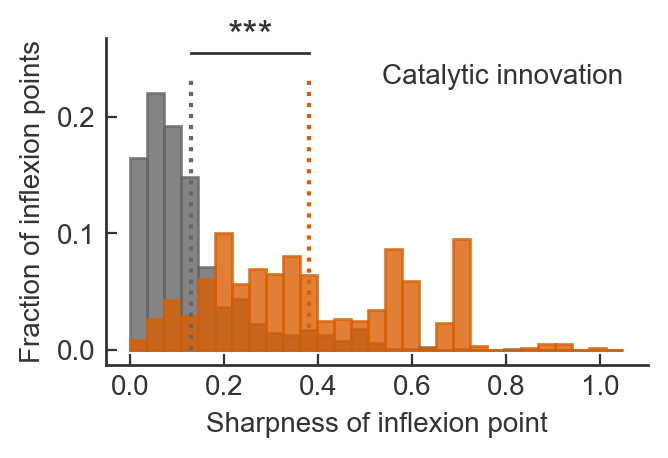

In [174]:
f = plt.figure(figsize=(3.5, 3.5/golden))
ax = plt.gca()
bins = np.linspace(0, 1.05, 30)
N = (map(len, Y))
print("Grey distribution, n=%s \nOrange distribution, n=%s"%(N[0], N[1]))
h1 = np.histogram(Y[0], bins, density=True)
h2 = np.histogram(Y[1], bins, density=True)
w = (h1[1][1] - h1[1][0])
for i in range(len(h1[0])):
    ax.fill([h1[1][i], h1[1][i], h1[1][i+1], h1[1][i+1]], [0, h1[0][i]*w, h1[0][i]*w, 0], color=azp.colors[7], alpha=0.8)
    ax.fill([h2[1][i], h2[1][i], h2[1][i+1], h2[1][i+1]], [0, h2[0][i]*w, h2[0][i]*w, 0], color=azp.colors[1], alpha=0.8)

#h1 = ax.hist(Y[0], bins, color=azp.colors[7], normed=1, alpha=0.8, label="No");
#h2 = ax.hist(Y[1], bins, color=azp.colors[1], normed=1, alpha=0.8, label="Yes");
ylim = ax.get_ylim()[1]
ax.plot([np.mean(Y[0])]*2, [0, ylim], ":", color=azp.colors[7])
ax.plot([np.mean(Y[1])]*2, [0, ylim], ":", color=azp.colors[1])
ax.plot(map(np.mean, Y), [ylim*1.1]*2, color="0.2", linewidth=1)
ax.text((np.mean(Y[1])+np.mean(Y[0]))*0.5, ylim*1.12, azp.what_pvalue(stats.mannwhitneyu(Y[0], Y[1]).pvalue), ha="center", fontsize=14)
ax.legend(loc='upper right', prop={'size': 10}, title="Catalytic innovation")
ax.set_ylabel("Fraction of inflexion points")
ax.set_xlabel("Sharpness of inflexion point")
f.savefig(str(cwd.joinpath("figures/4c.svg")), fmt='svg')

# Fig 4d

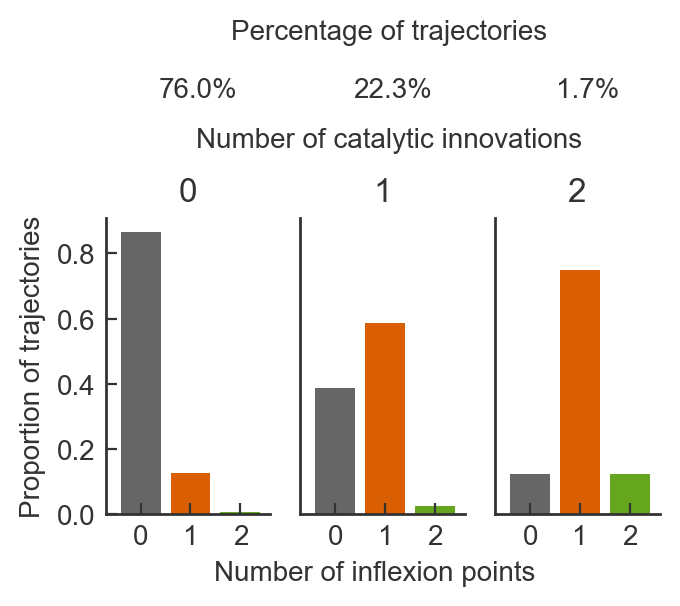

In [175]:
max_angle = 0.226
x = map(lambda x: sum(x[1:-1]), IX)
y = map(lambda x: sum([y > max_angle for y in x]), X)

df = pd.DataFrame(np.array([x, y]).T, columns=["x", "y"])
df = df.groupby(["x", "y"]).size().reset_index(name="counts")
f, axa = plt.subplots(1, 3, figsize=(3.5, 3.5/golden), sharey=True)
for i in range(3):
    ax = axa[i]
    colors = [azp.colors[_] for _ in [7, 1, 4]]
    for j in range(3):
        ax.bar(j, df[(df.x == i) & (df.y == j)].counts.values[0]/float(df[df.x == i].counts.sum()), color=colors[j])
    if i > 0: ax.axes.get_yaxis().set_visible(False)
    else: ax.set_ylabel("Proportion of trajectories")
    ax.set_xticks(range(3))
    ax.set_xlim(-0.7, 2.6)
    ax.text(1.15, 1.28, "%.1f%%"%(df[df.x == i].counts.sum()/float(df.counts.sum())*100), fontsize=10, ha="center")
    ax.set_title(i)
f.text(0.55, 0, "Number of inflexion points", ha="center")
f.text(0.57, 1, "Number of catalytic innovations", ha="center")
f.text(0.57, 1.25, "Percentage of trajectories", ha="center")
f.tight_layout()
f.savefig(str(cwd.joinpath("figures/4bdsvg")), fmt='svg')

# 4E

In [9]:
"""
Random trajectories were computed using random_trajectories/compute_trajectories.sh, data is analysed here. 
Because data files are too large, they are not included in the repositery but are available on request and/or can be re-computed.
"""
res = []
list_spec = [4, 8, 12, 16, 20, 24]
for nb_spec in list_spec:
    df = pd.read_csv("network_trajectories_alph_%s.csv"%nb_spec, names=["nb_spec", "nb_links"] + ["p_%s"%i for i in range(100)] + ["nt_traj", "rates"], converters={"rates":str})
    df["p"] = df.apply(lambda x: "_".join(["%.4f"%(x.get("p_%s"%i)) for i in range(min(100-1, nb_spec**2-1))]), axis=1)
    df.drop(["p_%s"%i for i in range(100)], inplace=True, axis=1)
    y = np.vstack((df.p.apply(lambda x: [0.] + map(float, x.split("_")))))
    dy = np.diff(y, axis=1)
    ddy = np.diff(dy, axis=1)
    ip = np.abs(np.diff(ddy, axis=1) * (np.diff(np.sign(ddy), axis=1) == -2))
    res.append(pd.DataFrame([[nb_spec]*len(df), list(df.nb_links.values), list(df.nt_traj.values), list(df.rates.values), list(df.p.values), map(lambda x: "_".join(["%.4f"%_ for _ in x]), ip)]).T)
df = pd.concat(res, axis=0)
df.columns = ["nb_spec", "nb_links", "nt_traj", "rates", "p", "ip"]

In [10]:
which = "percentile"
if which == "fixed":
    th = 0.125
elif which == "percentile":
    th_dict = {}
    for nb_spec in list_spec:
        x = np.hstack(df[df.nb_spec == nb_spec].ip.apply(lambda x: map(float, x.split("_"))).values)
        th = np.percentile(x[x > 0], 75)
        th_dict[nb_spec] = th
        print(nb_spec, th)
df["nb_jumps"] = df.apply(lambda x: sum(np.array(map(float, (x.ip).split("_"))) > th_dict[x.nb_spec]), axis=1)

nb_traj_total = {}
for name, group in df.groupby(["nb_spec", "nb_links"]).size().reset_index(name="total_nb_traj").groupby("nb_spec"):
    nb_traj_total[name] = {x.nb_links:float(x.total_nb_traj) for _, x in group.iterrows()}

(4, 0.222)
(8, 0.057)
(12, 0.034)
(16, 0.033)
(20, 0.032)
(24, 0.031)


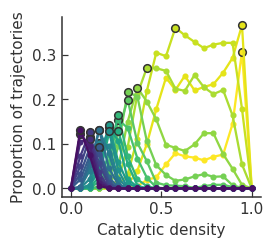

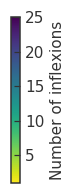

In [26]:
nb_spec = 24
y = df[df.nb_spec == nb_spec].groupby(["nb_links", "nb_jumps"]).size().reset_index(name="nb_traj").pivot(index="nb_links", columns="nb_jumps", values="nb_traj").fillna(0)
y_ = (y.values/np.vstack([nb_traj_total[nb_spec].values()]*y.shape[1]).T)
f = plt.figure(figsize=(7./3, 3.5/golden))
ax = plt.gca()
nb_max = 25
cmap = mpl.cm.get_cmap("viridis_r")
norm = mpl.colors.Normalize(vmin=1, vmax=nb_max)
for i in range(1, nb_max):
    ax.plot(y.index/float(nb_spec**2), y_[:, i], '.-', label=str(i), color=cmap(norm(i)))
    ax.plot((y.index/float(nb_spec**2))[y_[:, i].argmax()], y_[:, i].max(), '.', color=cmap(norm(i)), mec="0.2", ms=10)
#ax.legend(loc="upper left", ncol=4, title="Number of inflexions", labelspacing=0.1, handlelength=0.1, handletextpad=0.5, columnspacing=0.8, bbox_to_anchor=(1, 1))
ax.set_xlabel("Catalytic density")
ax.set_ylabel("Proportion of trajectories")
f.savefig(os.getcwd() + "/figures/4e.svg", fmt="svg")
f = plt.figure(figsize=(0.1, 2))
ax = plt.gca()
cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm)
cb.set_label("Number of inflexions")
f.savefig(os.getcwd() + "/figures/4e_cbar.svg", fmt="svg")

# 4F

['3.35', '3.17', '2.80', '2.43', '2.38']
[3163, 1000, 290, 42, 8]

['3.83', '3.88', '4.17', '4.46', '4.73', '4.83', '4.89', '5.04', '4.92', '4.77', '4.87', '4.43', '4.32', '4.21', '3.97', '3.37', '3.70', '3.52', '3.60']
[14074, 10024, 7359, 5916, 4986, 4288, 3621, 3079, 2577, 2115, 1646, 1206, 801, 522, 272, 138, 56, 21, 5]

['3.80', '3.86', '4.00', '4.09', '4.26', '4.46', '4.63', '4.79', '4.80', '4.94', '5.08', '5.28', '5.30', '5.27', '5.29', '5.29', '5.18', '5.05', '4.90', '4.80', '4.62', '4.61', '4.34', '4.16', '4.09', '3.55', '3.38', '3.66', '2.84', '2.67', '2.33']
[16653, 13982, 10696, 8192, 6712, 5859, 5242, 4757, 4349, 3985, 3684, 3404, 3110, 2851, 2632, 2380, 2148, 1922, 1669, 1397, 1140, 895, 662, 449, 284, 177, 96, 47, 19, 6, 3]

['3.78', '3.81', '3.92', '4.06', '4.18', '4.37', '4.45', '4.65', '4.84', '4.80', '4.89', '5.06', '5.18', '5.13', '5.20', '5.08', '5.16', '5.12', '4.80', '4.80', '4.57', '4.75', '4.21', '4.30', '4.23', '3.81', '3.61', '3.63', '3.32', '3.00', '2.50']
[

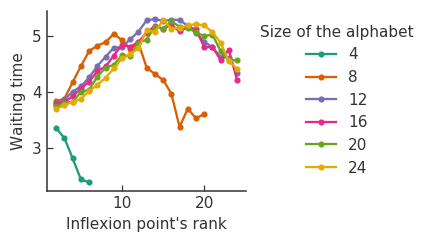

In [35]:
f = plt.figure(figsize=(7./3, 3.5/golden))
ax = plt.gca()
xlim = 23
for j, nb_spec in enumerate(list_spec[:]):
    if j >= 0:
        temp = df[(df.nb_spec == nb_spec) & (df.nb_jumps > 1)]
        if len(temp) > 0:
            y = map(lambda x: np.array([i for i in range(len(x)) if x[i] > th_dict[nb_spec]]), temp.ip.apply(lambda x: map(float, x.split("_"))))
            y = map(lambda x: np.diff(x), y)
            dy = [len([x[i] for x in y if len(x) > i]) for i in range(max(map(len, y)))]
            y = [np.mean([x[i] for x in y if len(x) > i]) for i in range(max(map(len, y)))]
            print(map(lambda x: "%.2f"%x, y))
            print(dy)
            print("")
        if len(y) > xlim:
            ax.plot(range(2, xlim+2), y[:xlim], '.-', color=azp.colors[j], label=str(nb_spec))
        else:
            ax.plot(range(2, len(y)+2), y, '.-', color=azp.colors[j], label=str(nb_spec))
ax.legend(title="Size of the alphabet", bbox_to_anchor=(1, 1))
ax.set_ylabel("Waiting time")
ax.set_xlabel("Inflexion point's rank")
#ax.set_xticks(np.arange(xlim)[::2])
f.savefig(os.getcwd() + "/figures/4f.svg", fmt="svg")

# 4G

In [20]:
def return_list_G(nb_spec):
    list_G = [(i, j) for i in range(nb_spec) for j in range(nb_spec)]
    return list_G

list_of_list_G = {nb_spec:return_list_G(nb_spec) for nb_spec in list_spec}

def degree(g, x, norm, deg, rates, list_G):
    M = network_matrix(x, rates, list_G)
    x = transform(x, list_G)
    assert type(x) == list
    if norm == 1:
        if M.sum() == 0:
            return 1./x.count("1")
        if deg == "in":
            return M.sum(1)[x.index(g)]/M.sum()
        else:
            return M.sum(0)[x.index(g)]/M.sum()
    else:
        if deg == "in":
            return M.sum(1)[x.index(g)]
        else:
            return M.sum(0)[x.index(g)]
        
def network_matrix(nt, rates, list_G):
    if type(nt) == str: nt = transform(nt, list_G)
    n = len(nt)
    M = np.zeros((n, n))
    for i in xrange(n):
        for j in xrange(n):
            M[i,j] = rates[(nt[j][0], nt[i][1])]
    return M

def transform(x, list_G):
    if x == None:
        return x
    elif type(x) == list:
        return "".join(map(str, [int(g in x) for g in list_G]))
    else:
        return [list_G[i] for i in xrange(len(list_G)) if x[i] == '1']

def compute_mut_out_degree(x):
    list_G = list_of_list_G[x.nb_spec]
    rates = {list_G[i]:float(x.rates[i]) for i in range(len(list_G))}
    nt_traj = x.nt_traj.split("_")
    nt_diff = [azm.compute_diff(nt_traj[i], nt_traj[i+1]) for i in range(len(nt_traj)-1)]
    nt_diff = map(lambda x: x.index(min(x)), nt_diff)
    out_degree = [degree(list_G[nt_diff[i]], nt_traj[i+1], 0, 'out', rates, list_G) for i in range(len(nt_traj)-1)]
    return "_".join(map(str, out_degree))

def nb_target_jump(x):
    ip = map(float, x.ip.split("_"))
    nb = map(float, x.nb_targets.split("_"))
    return "_".join(map(str, [nb[i] for i in range(len(nb)-1) if ip[i] > th_dict[x.nb_spec]]))

In [15]:
%%time
#This takes a while and needs quite some RAM to fit into memory
df["nb_targets"] = df.apply(compute_mut_out_degree, axis=1)

Wall time: 2h 4min 55s


4
8
12
16
20
24
Wall time: 1min 11s


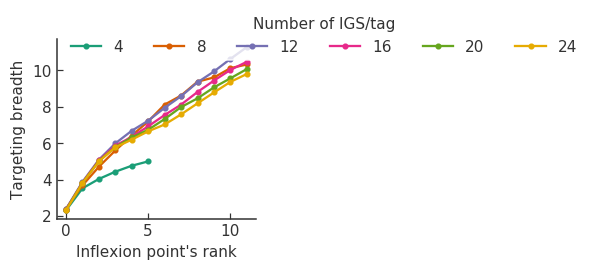

In [21]:
%%time
f = plt.figure(figsize=(7./3, 3.5/golden))
ax = plt.gca()

for j, nb_spec in enumerate(list_spec):
    print(nb_spec)
    temp = df[(df.nb_spec == nb_spec) & (df.nb_jumps > 0)]
    if len(temp) > 0:
        y = map(lambda x: map(float, x.split("_")), list(temp.apply(nb_target_jump, axis=1)))
        y = [np.mean([x[i] for x in y if len(x) > i]) for i in range(max(map(len, y)))]
        if len(y) < 12:
            ax.plot(range(len(y)), y, '.-', color=azp.colors[j], label=str(nb_spec))
        else:
            ax.plot(range(12), y[:12], '.-', color=azp.colors[j], label=str(nb_spec))
            
ax.legend(title="Number of IGS/tag", bbox_to_anchor=(0, 1.2), ncol=6)
ax.set_ylabel("Targeting breadth")
ax.set_xlabel("Inflexion point's rank")
f.savefig(os.getcwd() + "/figures/4g.svg", fmt="svg")

4
8
12
16
20
24
Wall time: 1min 9s


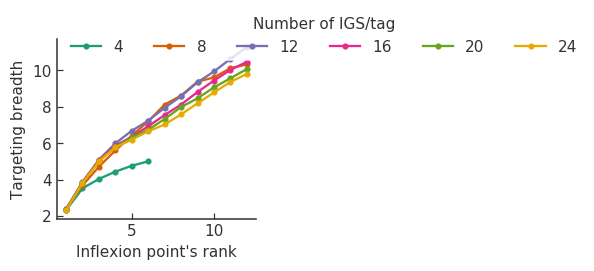

In [49]:
%%time
f = plt.figure(figsize=(7./3, 3.5/golden))
ax = plt.gca()

for j, nb_spec in enumerate(list_spec):
    print(nb_spec)
    temp = df[(df.nb_spec == nb_spec) & (df.nb_jumps > 0)]
    if len(temp) > 0:
        y = map(lambda x: map(float, x.split("_")), list(temp.apply(nb_target_jump, axis=1)))
        y = [np.mean([x[i] for x in y if len(x) > i]) for i in range(max(map(len, y)))]
        max_nb = 12
        if len(y) < max_nb:
            ax.plot(range(1, len(y)+1), y, '.-', color=azp.colors[j], label=str(nb_spec))
        else:
            ax.plot(range(1, max_nb+1), y[:max_nb], '.-', color=azp.colors[j], label=str(nb_spec))
            
ax.legend(title="Number of IGS/tag", bbox_to_anchor=(0, 1.2), ncol=6)
ax.set_ylabel("Targeting breadth")
ax.set_xlabel("Inflexion point's rank")
f.savefig(os.getcwd() + "/figures/4g.svg", fmt="svg")

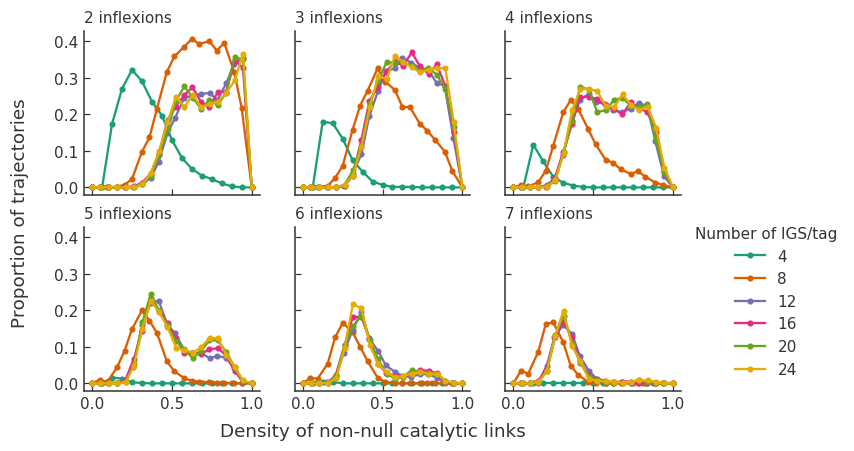

In [24]:
#For Extended Data Figures
f, axa = plt.subplots(2, 3, figsize=(7, 3.5/golden*2), sharex=True, sharey=True)
for k, j in enumerate(range(2, 8)):
    ax = axa[k/3, k%3]
    temp = df.groupby(["nb_spec", "nb_links", "nb_jumps"]).size().reset_index(name="nb_traj")
    for nb_spec in list_spec:
        y = temp[temp.nb_spec == nb_spec]
        y = y.pivot(index="nb_links", columns="nb_jumps", values="nb_traj").fillna(0)
        for i in range(y.columns.max()+1, 50):
            y["%s"%i] = np.zeros(len(y))
        x = y.index.values
        y = np.array([y.values[i, j]/nb_traj_total[nb_spec][x[i]] for i in range(len(y))])
        ax.plot(x/float(nb_spec**2), y, '.-', label=str(nb_spec))
    ax.set_title("%s inflexions"%j, loc="left", fontsize=10)
axa[1, 2].legend(loc="lower left", bbox_to_anchor=(1, 0), title="Number of IGS/tag")
f.text(0.03, 0.5, "Proportion of trajectories", rotation=90, va="center", fontsize=12)
f.text(0.5, 0.03, "Density of non-null catalytic links", ha="center", fontsize=12)
f.savefig(os.getcwd() + "/extended_data_figures/10b.svg", fmt="svg")

# Format data for supplementary files

### Data for the 1,837 networks

In [78]:
temp = data_[:]
nb_replicates = dict(data_f.groupby("az_list").size())
temp["replicates"] = temp.az_list.apply(lambda x: nb_replicates[x])
for g in G:
    temp[g] = temp.apply(lambda x: "" if g not in azm.transform(x.az_list) else "%.2f"%x.get(g), axis=1)

C:\Users\Simon\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Simon\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [83]:
temp[G + ["replicates"]].to_excel("network_data.xlsx", index=False)

### Data for the 20,000 droplets

In [15]:
temp = data_f[:]
for g in G:
    temp[g] = temp.apply(lambda x: "" if g not in azm.transform(x.az_list) else "%.2f"%(x.get(g)/(x.az_correct*x.az_total)), axis=1)

In [21]:
temp.get(G + ["az_list"]).to_excel("droplet_data.xlsx", index=False)